In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, max_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
import pickle
from typing import Sequence

In [2]:
"""
Parameters:
    df: 'dataframe' structured like in csv files
    scale: 'bool', request to standardize data, default=False
    start: 'int', representing the year where to start the timeseries
    stop: 'int', representing the year where to stop the timeseries

Output:
    DataFrame with the follwing structure:
        -> data   = values
        -> columns= country_name
        -> index  = year

Description:
    Basicly creates a multivariate time-series
"""
def reshape(df: pd.DataFrame, scale:bool =False, start=1960, stop=2016) -> pd.DataFrame:
    columns = df["Country Name"]
    index = range(start, stop+1)
    data = df[[f"{i}" for i in index]].to_numpy().T
    
    df = pd.DataFrame(data = data,
                        columns=columns,
                        index=index)
    if scale:
        df = ( df-df.mean() ) / df.std() 
    return df

In [3]:
filter_ = lambda df, country: df[df["Country Name"].isin(country)]

In [4]:
pop = pd.read_csv("data/country_population.csv")
pop.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0


In [5]:
reshape(pop).head()

Country Name,Aruba,Afghanistan,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,Armenia,American Samoa,...,Virgin Islands (U.S.),Vietnam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
1960,54211.0,8996351.0,5643182.0,1608800.0,13411.0,92490932.0,92634.0,20619075.0,1874120.0,20013.0,...,32500.0,32670629.0,63699.0,3.032160e+09,108646.0,947000.0,5172135.0,17456855.0,3044846.0,3747369.0
1961,55438.0,9166764.0,5753024.0,1659800.0,14375.0,95044497.0,101078.0,20953077.0,1941491.0,20486.0,...,34300.0,33666772.0,65713.0,3.073369e+09,112119.0,966000.0,5260501.0,17920673.0,3140264.0,3870756.0
1962,56225.0,9345868.0,5866061.0,1711319.0,15370.0,97682294.0,112472.0,21287682.0,2009526.0,21117.0,...,35000.0,34684165.0,67808.0,3.126510e+09,115788.0,994000.0,5351799.0,18401608.0,3240587.0,3999419.0
1963,56695.0,9533954.0,5980417.0,1762621.0,16412.0,100411076.0,125566.0,21621840.0,2077575.0,21882.0,...,39800.0,35722091.0,69964.0,3.191786e+09,119561.0,1022000.0,5446063.0,18899275.0,3345145.0,4132756.0
1964,57032.0,9731361.0,6093321.0,1814135.0,17469.0,103239902.0,138529.0,21953929.0,2144998.0,22698.0,...,40800.0,36780985.0,72131.0,3.257460e+09,123354.0,1050000.0,5543339.0,19412975.0,3452942.0,4269863.0


In [6]:
"""
Parameters:
    df: 'dataframe' structured like "reshape" function output, multivariate timeseries
    label: 'str', name for the column of the data

Description:
    Agglomerates all the different timeseries for each country in a single column.
    Each row as the country it refers to, one hot encoded.
    The data for each country is still ordered by year.
"""
def to_mvts(df: pd.DataFrame, label:str):
    encoder = LabelBinarizer().fit(df.columns)
    new_df = pd.DataFrame(columns = [label] + list(df.columns))
    
    for i, col in enumerate(df.columns):
        tseries = df[col]
        tseries.name = label
        #one hot encodes country
        encoded_country = pd.DataFrame(data=list(encoder.transform([col]))*len(tseries), 
                                       columns=encoder.classes_,
                                       index=tseries.index)
        #merges country timeseries with respective one hot encoding
        tseries = pd.concat((tseries, encoded_country), axis=1)
        new_df = pd.concat((new_df, tseries), sort=True)
    return new_df

In [7]:
def get_lags( X: pd.Series, lags):
        return pd.DataFrame(
            data={ f"-{i}": X.shift(i) for i in range(1,lags+1) }
        )

In [8]:
def to_lagged_mtvs_with_country(df: pd.DataFrame, lags=50):
    encoder = LabelBinarizer().fit(df.columns)
    new_df = pd.DataFrame(columns = ["y"] + list(df.columns))

    for col in df.columns:
        tseries = df[col]
        tseries.name = "y"
        encoded_country = pd.DataFrame(data=list(encoder.transform([col])) * len(tseries), 
                                       columns=encoder.classes_,
                                       index=tseries.index)
        tseries = pd.concat((tseries, 
                             get_lags(tseries, lags), 
                             encoded_country), 
                             axis=1)
        new_df = pd.concat((new_df, tseries), sort=True)
    return new_df, encoder

In [9]:
#multivariate_timeseries = to_mvts(reshape(pop), "Population")
multivariate_timeseries = pd.read_csv("data/mvts.csv", index_col=0)

multivariate_timeseries.head()

,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Arab World,Argentina,Armenia,...,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe
1960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
multivariate_timeseries.to_csv("data/mvts.csv")

In [11]:
"""
Class for the prediction of future values of a time-series;
Initalization Parameters:
    -> estimator: ML model to use in the forecast regression. !Must be a model from 'Sklearn' package!
    -> lags: 'int', how many previous years to take in consideration to make the prediction.

Non-initial Instances:
    -> raw: Default data that entered the model (output of 'reshape()' format)
    -> X: Independent variables used to train the model. Matrix that for each row/year as the *lags*
            previous years, as well as the one hot encoded country it belongs to.
    -> y: Dependent variable used to train the model. Time-series with the expected output
            for each element in X.
    -> min_year: The minimum year for which the model can make a prediction. Corresponds to 
                {year of the first entrance} + {lags}
    -> encoder: Model to one hot encode the country labels. Corresponds to sklearn 'LabelBinarizer' model

"""
class ForecastModel:
    def __init__(self, 
                 estimator = LinearRegression(), 
                 lags=5,
                 encode_country=True):
        self.estimator=estimator
        self.lags = lags
        self.encode_country = encode_country
    
    """
    Parameters:
        -> X: MVTS to train the model. Should be in format of "reshape" function output
        
    Description:
        Using input X mvts creates an instance 'y', and an instance 'X' (mentioned in "Non-initial Instances").
        Then saves the first year for which the model can make predictions ('min_year').
        Finally trains the estimator with the matrix data 'X' as the independent variables and
        'y' series as the dependent variable.
    """
    def fit(self, X, start=1960, stop=2016):
        self.raw = X
        
        mvts = self.__to_lagged_mvts(X.loc[start:stop])
        self.X = mvts.drop(columns="y")
        self.y = mvts["y"]
        
        self.min_year = self.X.index.min()
        self.estimator = self.estimator.fit(self.X, self.y)
        return self
    
    #similar function but skips by receiving parameters already runned
    #to speed up the search for the best parameters
    def faster_fit_country(self, X, lagged_data, encoder, start=1960, stop=2016):
        self.raw = X
        
        cols = [f"{-i}" for i in range(1, self.lags+1)] + list(encoder.classes_) + ["y"]
        lagged_data = lagged_data.loc[range(start+self.lags, stop+1), cols].dropna()
        
        self.X = lagged_data.drop(columns="y")
        self.y = lagged_data["y"]
        self.encoder=encoder
        
        self.min_year=self.X.index.min()
        self.estimator = self.estimator.fit(self.X, self.y)
        return self
    
    def faster_fit_no_country(self, X, lagged_data, start=1960, stop=2016):
        self.raw = X
        
        cols = [f"{-i}" for i in range(1, self.lags+1)] + ["y"]
        lagged_data = lagged_data.loc[range(start+self.lags, stop+1), cols].dropna()
        
        self.X = lagged_data.drop(columns="y")
        self.y = lagged_data["y"]
        
        self.min_year = self.X.index.min()
        self.estimator = self.estimator.fit(self.X, self.y)
        return self
    """
    Parameters:
        -> years: List of years for which to make the prediction. Must be an iterable
        -> country: 'str', Country for which to make the prediction
    
    Description:
        Iterates over the years and makes the predicted value using 
        data from {lags} last years from that country.
    """
    def predict(self, years: Sequence, country: str):
        X = []
        lags = range(1, self.lags+1)
        if self.encode_country:
            encoded_country = list(self.encoder.transform([country])[0])
            for year in years:
                assert(year>=self.min_year)
                X += [ 
                    [self.get_year(year - i, country) for i in lags] + encoded_country
                ]
        else:
            for year in years:
                assert(year>=self.min_year)
                X += [ 
                    [self.get_year(year - i, country) for i in lags]
                ]
            
        #model needed to have the labels that used in training
        X = pd.DataFrame(data = X,
                        columns = self.estimator.feature_names_in_)   
            
        return self.estimator.predict( X )
    
    """
    Parameters:
        -> year: 'int', year from which to get the data
        -> country: 'str', country from which to get the data
        
    Description:
        Returns data from {raw} located in ['year', 'country']. 
        If this data does not exist ( e.g. was not present in the training set) it
        is first predicted recursively. After this it is memoized in raw table, to
        avoid repeating the recursion.
    """
    def get_year(self, year: int, country : str) -> float:
        try: 
            data = self.raw.loc[year, country]
            if data == np.nan:
                raise Exception()
            return data
        except:
            pred = self.predict([year], country)[0]
            self.raw.loc[year, country] = pred
            return pred
    
    """
    Parameters:
        -> country: 'str' country label from which to get the data
    
    Description:
        Returns the timeseries that corresponds to 'country'
    """
    def get_country(self, country:str):
        if self.encode_country:
            return self.y[self.X[country]==1]
        return self.raw[country]
    
    """
    Parameters:
        -> df: MVTS to train the model. Should be in format of "reshape" function output
        -> sort: 'bool', tag to sort data based on index, default = 'False'
    
    Description:
        Creates a Matrix where each instance has the reference to the country it belongs to, one hot encoded.
        Besides this it also has the original time-series from 'df' in a column named "y", and {lags} columns with
        the data from previous years.
        It drops columns which do not have at least {lags} previous years to reference.
    """
    def __to_lagged_mvts(self, df: pd.DataFrame):
        if self.encode_country:
            self.encoder = LabelBinarizer().fit(df.columns)
            new_df = pd.DataFrame(columns = ["y"] + list(df.columns))
        
            for col in df.columns:
                tseries = df[col]
                tseries.name = "y"
                encoded_country = pd.DataFrame(data=list(self.encoder.transform([col])) * len(tseries), 
                                               columns=self.encoder.classes_,
                                               index=tseries.index)
                tseries = pd.concat((tseries, 
                                     self.__get_lags(tseries), 
                                     encoded_country), 
                                     axis=1).dropna()
                cols = [f"{-i}" for i in range(1, self.lags+1)] + list(self.encoder.classes_) + ["y"]
                new_df = pd.concat((new_df, tseries))[cols]
                
        else:
            new_df = pd.DataFrame(columns = ["y"])
            
            for col in df.columns:
                tseries = df[col]
                tseries.name = "y"

                tseries = pd.concat((tseries, 
                                     self.__get_lags(tseries)), 
                                     axis=1).dropna()
                new_df = pd.concat((new_df, tseries))
        return new_df
    
    """
    Parameters:
        -> X: Time-Series
    Description:
        Iteratively creates a matrix. Each column corresponds to the data
        from the ith previous year.
    """
    def __get_lags(self, X: pd.Series):
        return pd.DataFrame(
            data={ f"-{i}": X.shift(i) for i in range(1,self.lags+1) }
        )

In [12]:
countries = list(pop["Country Name"].sample(n=10, random_state=66))
pprint(list(enumerate(countries)))

[(0, 'Solomon Islands'),
 (1, 'Finland'),
 (2, 'Burkina Faso'),
 (3, 'Switzerland'),
 (4, 'Timor-Leste'),
 (5, 'Portugal'),
 (6, 'Chile'),
 (7, 'Bosnia and Herzegovina'),
 (8, 'Uruguay'),
 (9, 'Russian Federation')]


In [13]:
label = countries[5]

# Predicting on the **Training** Set with Simple Cross Validation

In [14]:
model = ForecastModel().fit(reshape(pop), stop=2015 )

In [15]:
train_pred = model.predict([2016], label)
real = model.raw.loc[2016,label]
err = mean_squared_error([real], train_pred, squared=False)
print(f"""Predicted value is: {train_pred[0]:.3f};
True value is: {real:.3f};

Root Mean Squared Error is: {err:.3f}
Error in relation to mean is: {err/model.get_country(label).mean():.4f}""")

Predicted value is: 10318078.379;
True value is: 10325452.000;

Root Mean Squared Error is: 7373.621
Error in relation to mean is: 0.0007


In [16]:
y_test = [ model.raw.loc[2016, label] for label in countries ]

In [17]:
preds = [ model.predict([2016], label)[0] for label in countries]
preds

[599475.187967268,
 5496047.051550509,
 18639136.93408485,
 8374886.735890649,
 1269297.326119287,
 10318078.378552373,
 17910773.87175823,
 3508000.7009068336,
 3443603.0838361057,
 144364501.52107537]

In [18]:
print(f"rmse = {mean_squared_error( y_test, preds, squared=False)}")

rmse = 8259.765944061844


In [19]:
print(f"Pearson Corr. Coef. = {np.corrcoef(y_test, preds)[0,1]}")

Pearson Corr. Coef. = 0.999999994658903


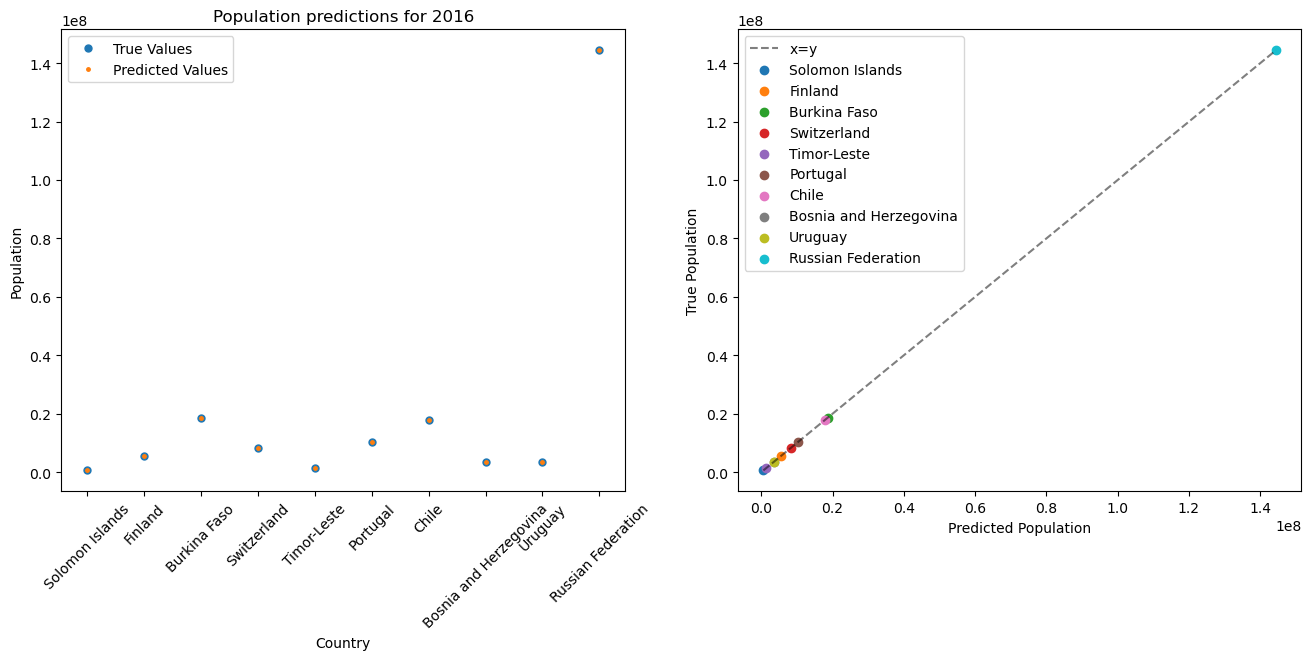

In [20]:
def plot_sub(ax, x, y, label="", xlabel="", ylabel="", title="", ms=5):
    ax.plot(x, y, ".", label=label, ms=ms)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label!="":
        ax.legend()

def scat_sub(ax, x, y, label="", xlabel="", ylabel="", title=""):
    ax.scatter(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label!="":
        ax.legend()

x_ = range(len(countries))
f, ax = plt.subplots(1,2, figsize=(16,6))
plot_sub(ax[0], x_, y_test, label="True Values", ms=10)
plot_sub(ax[0], x_, preds, label="Predicted Values", xlabel="Country", ylabel="Population", title="Population predictions for 2016")
ax[0].set_xticks(x_, countries, rotation=45)

xy=np.linspace(min(preds), max(preds))
ax[1].plot(xy,xy, "k--", alpha=0.5, label="x=y")
for i, country in enumerate(countries):
    scat_sub(ax[1], [preds[i]], [y_test[i]], xlabel="Predicted Population", ylabel="True Population", label=country)

# Best Parameter Search using **Simple Cross Validation**

In [21]:
def search_best_no_country( X,
                            lagged_data,
                            countries = countries,
                            estimator = LinearRegression, 
                            lags: Sequence = [5], 
                            from_year = [1960],
                            metric = "pearson",
                            *args,
                            **kwargs):
    rmse = []
    pearson = []
    models = []
    parameters=[]
    
    test = X.loc[2016, countries]
    print(f"Number of iterations: {len(lags) * len(from_year)}")
    i=0
    for lag in lags:
        for start_year in from_year:
            i+=1
            if i%200==0: print("Iteration Nº:", i)
            
            time_diff = 2015 - start_year
            #if lag<time_diff:
            try:
                model = ForecastModel(estimator=estimator(**kwargs), 
                                       lags=lag,
                                      encode_country=False
                                     ).faster_fit_no_country( X, 
                                                               lagged_data,
                                                               start=start_year,
                                                               stop=2015)
                
                preds = [ model.predict([2016], country)[0] for country in countries ]
                rmse.append( mean_squared_error(test, preds, squared=False) )
                pearson.append( np.corrcoef(test, preds)[0,1] )
                models.append(model)
                parameters.append({"lags":lag, 
                                   "encode_country":False, 
                                   "train_range": (start_year, 2015)})
            except Exception as e:
                continue
    if metric == "pearson":
        idx = np.argmax(pearson)
    if metric == "rmse":
        idx = np.argmin(rmse)
    
    print("Processing Finished!")
    return (models[idx], 
            parameters[idx], 
            rmse[idx], 
            rmse[idx]/test.mean(),
            pearson[idx],
            {
             "params": parameters, 
             "pearson":pearson, 
             "rmse":rmse
            })

In [22]:
def search_best_encode_country( X,
                                lagged_data,
                                encoder,
                                countries = countries,
                                estimator = LinearRegression, 
                                lags: Sequence = [5], 
                                from_year = [1960],
                                metric = "pearson",
                                *args,
                                **kwargs
                              ):
    rmse = []
    pearson = []
    models = []
    parameters=[]
    test = X.loc[2016, countries]
    
    print(f"Number of iterations: {len(lags) * len(from_year)}")
    i=0
    for lag in lags:
        for start_year in from_year:
            i+=1
            if i%200==0: print("Iteration Nº:", i)
            
            try:
                model = ForecastModel(estimator=estimator(**kwargs), 
                                       lags=lag
                                     ).faster_fit_country( X, 
                                                           lagged_data,
                                                           encoder,
                                                           start=start_year,
                                                           stop=2015)

                
                preds = [ model.predict([2016], country)[0] for country in countries ]
                rmse.append( mean_squared_error(test, preds, squared=False) )
                pearson.append( np.corrcoef(test, preds)[0,1] )
                models.append(model)
                parameters.append({"lags":lag, 
                                   "encode_country":True, 
                                   "train_range": (start_year, 2015)})
            except Exception as e:
                continue
    if metric == "pearson":
        idx = np.argmax(pearson)
    if metric == "rmse":
        idx = np.argmin(rmse)
    
    print("Processing Finished!")
    return (models[idx], 
            parameters[idx], 
            rmse[idx], 
            rmse[idx]/test.mean(),
            pearson[idx], 
            {
                "params":parameters, 
                "pearson":pearson, 
                "rmse":rmse
            })

In [23]:
def save_results(fname, *args):
    pickle.dump(args, open(fname, "wb"))

In [24]:
def get_results(fname):
    return pickle.load(open(fname, "rb"))

In [25]:
def print_all(*args):
    print(f"""
    Best Parameters: {args[0]}
    Best RMSE: {args[1]}
    Best Pearson Corr.: {args[2]}
    RMSE Relative to Mean: {args[3]}
    """)

# Search Best Parameters For Country Population

In [30]:
pop = pd.read_csv("data/country_population.csv")
data = reshape(pop)

In [31]:
data_lagged, encoder = to_lagged_mtvs_with_country(reshape(pop))

### Without Reference To Country

In [102]:
cols=[f"{-i}" for i in range(1,50+1)] + ["y"]
# Searching without country reference

(best_model, 
 best_params, 
 best_rmse, 
 relative_rmse,
 best_pcorr,
results) = search_best_no_country(X=data,
                            lagged_data=data_lagged[cols],
                            estimator=DecisionTreeRegressor,max_depth=5,
                            lags=range(1,50),
                            from_year=range(1960, 2010+1),
                           )

Number of iterations: 2499
Iteration Nº: 200
Iteration Nº: 400
Iteration Nº: 600
Iteration Nº: 800
Iteration Nº: 1000
Iteration Nº: 1200
Iteration Nº: 1400
Iteration Nº: 1600
Iteration Nº: 1800
Iteration Nº: 2000
Iteration Nº: 2200
Iteration Nº: 2400
Processing Finished!


In [104]:
print("Best by Pearson:")
print_all(best_params, best_rmse, best_pcorr, relative_rmse)

Best by Pearson:

    Best Parameters: {'lags': 30, 'encode_country': False, 'train_range': (1972, 2015)}
    Best RMSE: 0.2653188575575845
    Best Pearson Corr.: 0.9994860414705538
    RMSE Relative to Mean: 0.003531502085273664
    


In [105]:
idx = np.argmin(results["rmse"])

print("Best by RMSE:")
print_all(results["params"][idx], results["rmse"][idx], results["pearson"][idx], results["rmse"][idx]/reshape(pop).loc[2016, countries].mean())

Best by RMSE:

    Best Parameters: {'lags': 7, 'encode_country': False, 'train_range': (1995, 2015)}
    Best RMSE: 0.23443261440363572
    Best Pearson Corr.: 0.9994583892158754
    RMSE Relative to Mean: 1.0958857882916889e-08
    


In [106]:
save_results("dtmd5_no_country.pickle", best_model, best_params, best_rmse, best_pcorr)

### With Reference To Country

In [41]:
# Searching without country reference
(best_model, 
 best_params, 
 best_rmse, 
 relative_rmse,
 best_pcorr,
results) = search_best_encode_country(X=data,
                                      lagged_data=data_lagged,
                                      encoder=encoder,
                                      estimator=DecisionTreeRegressor,
                                      lags=range(1,50),
                                      from_year=range(1960, 2010+1),
                                    )

Number of iterations: 2499
Iteration Nº: 200
Iteration Nº: 400
Iteration Nº: 600
Iteration Nº: 800
Iteration Nº: 1000
Iteration Nº: 1200
Iteration Nº: 1400
Iteration Nº: 1600
Iteration Nº: 1800
Iteration Nº: 2000
Iteration Nº: 2200
Iteration Nº: 2400
Processing Finished!


In [42]:
print("Best by Pearson:")
print_all(best_params, best_rmse, best_pcorr, relative_rmse)

Best by Pearson:

    Best Parameters: {'lags': 8, 'encode_country': True, 'train_range': (1962, 2015)}
    Best RMSE: 80602.88430695269
    Best Pearson Corr.: 0.9999998768423168
    RMSE Relative to Mean: 0.003767886803293644
    


In [43]:
idx = np.argmin(results["rmse"])

print("Best by RMSE:")
print_all(results["params"][idx], results["rmse"][idx], results["pearson"][idx], results["rmse"][idx]/reshape(pop).loc[2016, countries].mean())

Best by RMSE:

    Best Parameters: {'lags': 23, 'encode_country': True, 'train_range': (1964, 2015)}
    Best RMSE: 79213.41349291797
    Best Pearson Corr.: 0.9999998740224162
    RMSE Relative to Mean: 0.0037029341804591344
    


In [44]:
best_model = ForecastModel(lags = 8).fit(reshape(pop), start=1962, stop=2015)

In [45]:
best_model.X

,-1,-2,-3,-4,-5,-6,-7,-8,Afghanistan,Albania,...,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe
1970,58726.0,58386.0,58055.0,57715.0,57360.0,57032.0,56695.0,56225.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1971,59063.0,58726.0,58386.0,58055.0,57715.0,57360.0,57032.0,56695.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1972,59440.0,59063.0,58726.0,58386.0,58055.0,57715.0,57360.0,57032.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1973,59840.0,59440.0,59063.0,58726.0,58386.0,58055.0,57715.0,57360.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1974,60243.0,59840.0,59440.0,59063.0,58726.0,58386.0,58055.0,57715.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,14086317.0,13810599.0,13558469.0,13329909.0,13124267.0,12940032.0,12777511.0,12633897.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2012,14386649.0,14086317.0,13810599.0,13558469.0,13329909.0,13124267.0,12940032.0,12777511.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2013,14710826.0,14386649.0,14086317.0,13810599.0,13558469.0,13329909.0,13124267.0,12940032.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2014,15054506.0,14710826.0,14386649.0,14086317.0,13810599.0,13558469.0,13329909.0,13124267.0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [46]:
save_results("dt_country.pickle", best_model, results["params"][idx], results["rmse"][idx], results["pearson"][idx])

## Results For Country Population Dataset

> Statistics obtained with train test split

| Statistic | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| Pearson Corr. | 0.999999999053 | ? | 0.9999998768423168 |
| RMSE | 1847.51 | ? | 80602.88 |
| RMSE Relative to MEAN| 8.636 e-5 | ? | 0.0037029341804591344 |

> Best parameters obtained

| Parameter | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| lags | 4 | ? | 8 |
| start | 2010 | ? | 1962 |
| stop | 2015 | ? | 2015 |
| encode_country | True | ? | True |

## Predicting Country Population for 2017 on the **Test** Set

In [47]:
y_test=pd.read_csv("data/country_population_test.csv", index_col=0).loc[2017]
y_test

Solomon Islands              636030.0
Finland                     5508214.0
Burkina Faso               19193236.0
Switzerland                 8451840.0
Timor-Leste                 1243260.0
Portugal                   10300300.0
Chile                      18470435.0
Bosnia and Herzegovina      3351534.0
Uruguay                     3436645.0
Russian Federation        144496739.0
Name: 2017, dtype: float64

In [48]:
model = ForecastModel(lags=8).fit(data, start=1962, stop=2016)

In [49]:
model.X

,-1,-2,-3,-4,-5,-6,-7,-8,Afghanistan,Albania,...,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe
1970,58726.0,58386.0,58055.0,57715.0,57360.0,57032.0,56695.0,56225.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1971,59063.0,58726.0,58386.0,58055.0,57715.0,57360.0,57032.0,56695.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1972,59440.0,59063.0,58726.0,58386.0,58055.0,57715.0,57360.0,57032.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1973,59840.0,59440.0,59063.0,58726.0,58386.0,58055.0,57715.0,57360.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1974,60243.0,59840.0,59440.0,59063.0,58726.0,58386.0,58055.0,57715.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,14386649.0,14086317.0,13810599.0,13558469.0,13329909.0,13124267.0,12940032.0,12777511.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2013,14710826.0,14386649.0,14086317.0,13810599.0,13558469.0,13329909.0,13124267.0,12940032.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2014,15054506.0,14710826.0,14386649.0,14086317.0,13810599.0,13558469.0,13329909.0,13124267.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2015,15411675.0,15054506.0,14710826.0,14386649.0,14086317.0,13810599.0,13558469.0,13329909.0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [50]:
preds = [ model.predict([2017], label)[0] for label in countries]
preds

[611351.1576457825,
 5510004.685105728,
 19186022.563910145,
 8458382.962836659,
 1295383.8814666881,
 10302498.367218781,
 18056552.481722504,
 3503437.1594226407,
 3456714.701155616,
 144565456.8473741]

In [51]:
print(f"rmse = {mean_squared_error( y_test, preds, squared=False)}")

rmse = 142452.4734443344


In [52]:
print(f"Pearson Corr. Coef. = {np.corrcoef(y_test, preds)[0,1]}")

Pearson Corr. Coef. = 0.9999942217649116


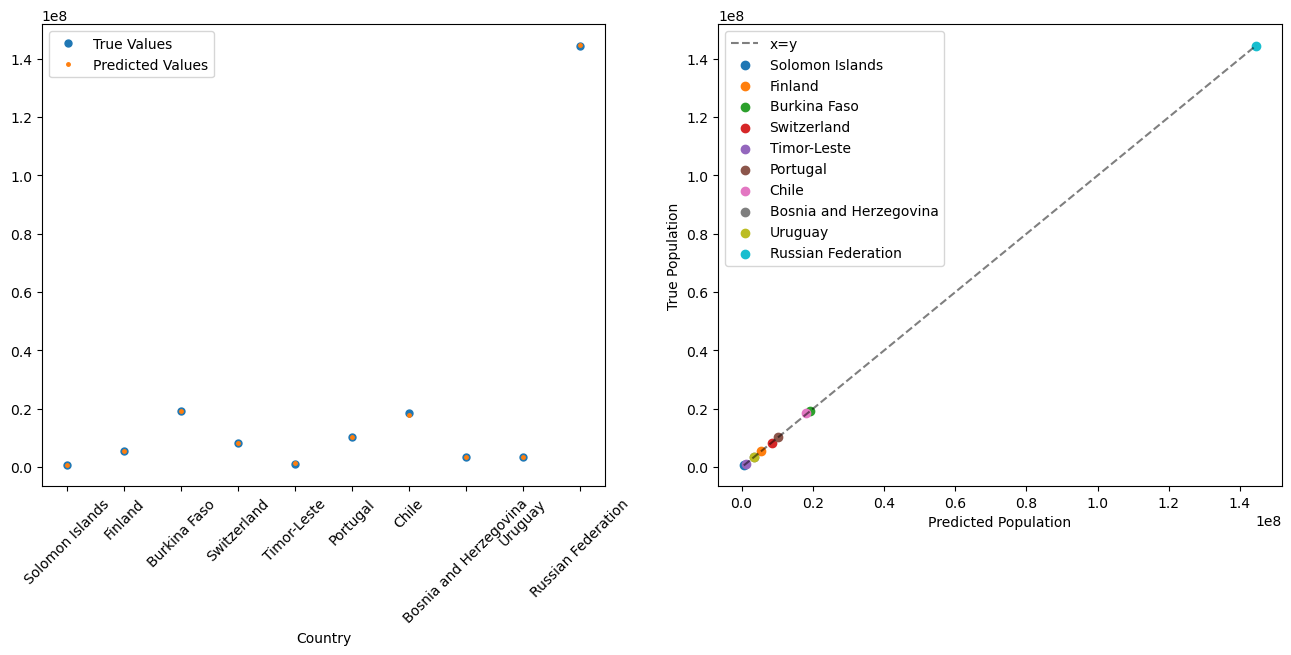

In [53]:
x_ = range(len(countries))
f, ax = plt.subplots(1,2, figsize=(16,6))
plot_sub(ax[0], x_, y_test, label="True Values", ms=10)
plot_sub(ax[0], x_, preds, label="Predicted Values", xlabel="Country")
ax[0].set_xticks(x_, countries, rotation=45)

xy=np.linspace(min(preds), max(preds))
ax[1].plot(xy,xy, "--k", alpha=0.5, label="x=y")
for i, country in enumerate(countries):
    scat_sub(ax[1], [preds[i]], [y_test[i]], xlabel="Predicted Population", ylabel="True Population", label=country)

# Search Best Parameters for Fertility Rate

In [26]:
fert_rate = pd.read_csv("data/fertility_rate.csv")
data = reshape(fert_rate)

In [27]:
data_lagged, encoder = to_lagged_mtvs_with_country(data)

## Without Country Information

In [28]:
cols=[f"{-i}" for i in range(1,50+1)] + ["y"]
# Searching without country reference
(best_model, 
 best_params, 
 best_rmse, 
 relative_rmse,
 best_pcorr,
results) = search_best_no_country(X=data,
                            lagged_data=data_lagged[cols],
                            estimator=DecisionTreeRegressor,
                            lags=range(1,50),
                            from_year=range(1960, 2010+1),
                           )

Number of iterations: 2499
Iteration Nº: 200
Iteration Nº: 400
Iteration Nº: 600
Iteration Nº: 800
Iteration Nº: 1000
Iteration Nº: 1200
Iteration Nº: 1400
Iteration Nº: 1600
Iteration Nº: 1800
Iteration Nº: 2000
Iteration Nº: 2200
Iteration Nº: 2400
Processing Finished!


In [29]:
print("Best by Pearson:")
print_all(best_params, best_rmse, best_pcorr, relative_rmse)

Best by Pearson:

    Best Parameters: {'lags': 48, 'encode_country': False, 'train_range': (1967, 2015)}
    Best RMSE: 0.042656769685479046
    Best Pearson Corr.: 0.9999918398913125
    RMSE Relative to Mean: 0.016352988186880982
    


In [30]:
idx = np.argmin(results["rmse"])

print("Best by RMSE:")
print_all(results["params"][idx], results["rmse"][idx], results["pearson"][idx], results["rmse"][idx]/reshape(fert_rate).loc[2016, countries].mean())

Best by RMSE:

    Best Parameters: {'lags': 10, 'encode_country': False, 'train_range': (1992, 2015)}
    Best RMSE: 0.010741694465958377
    Best Pearson Corr.: 0.9999858499883637
    RMSE Relative to Mean: 0.004117958392163457
    


In [31]:
best_model = ForecastModel(lags=11, encode_country=False).fit(data, start = 1996, stop=2015)

In [97]:
best_model.X

,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11
2007,1.766,1.774,1.787,1.803,1.823,1.846,1.872,1.903,1.939,1.978,2.021
2008,1.763,1.766,1.774,1.787,1.803,1.823,1.846,1.872,1.903,1.939,1.978
2009,1.764,1.763,1.766,1.774,1.787,1.803,1.823,1.846,1.872,1.903,1.939
2010,1.769,1.764,1.763,1.766,1.774,1.787,1.803,1.823,1.846,1.872,1.903
2011,1.776,1.769,1.764,1.763,1.766,1.774,1.787,1.803,1.823,1.846,1.872
...,...,...,...,...,...,...,...,...,...,...,...
2011,4.028,4.024,4.014,4.001,3.991,3.985,3.984,3.989,4.001,4.022,4.055
2012,4.019,4.028,4.024,4.014,4.001,3.991,3.985,3.984,3.989,4.001,4.022
2013,3.996,4.019,4.028,4.024,4.014,4.001,3.991,3.985,3.984,3.989,4.001
2014,3.957,3.996,4.019,4.028,4.024,4.014,4.001,3.991,3.985,3.984,3.989


In [32]:
save_results("fert_rate_dt.pickle", best_model, results["rmse"][idx], results["pearson"][idx])

## With Country Information

In [41]:
(best_model, 
 best_params, 
 best_rmse, 
 relative_rmse,
 best_pcorr,
results) = search_best_encode_country(  X=data,
                                        lagged_data=data_lagged,
                                        encoder=encoder,
                                        estimator=DecisionTreeRegressor,
                                        lags=range(1,50),
                                        from_year=range(1960, 2010+1),
                                       )

Number of iterations: 2499
Iteration Nº: 200
Iteration Nº: 400
Iteration Nº: 600
Iteration Nº: 800
Iteration Nº: 1000
Iteration Nº: 1200
Iteration Nº: 1400
Iteration Nº: 1600
Iteration Nº: 1800
Iteration Nº: 2000
Iteration Nº: 2200
Iteration Nº: 2400
Processing Finished!


In [42]:
print("Best by Pearson:")
print_all(best_params, best_rmse, best_pcorr, relative_rmse)

Best by Pearson:

    Best Parameters: {'lags': 6, 'encode_country': True, 'train_range': (1995, 2015)}
    Best RMSE: 0.011597413504743272
    Best Pearson Corr.: 0.9999903531935371
    RMSE Relative to Mean: 0.004446008627465314
    


In [43]:
idx = np.argmin(results["rmse"])

print("Best by RMSE:")
print_all(results["params"][idx], results["rmse"][idx], results["pearson"][idx], results["rmse"][idx]/data.loc[2016, countries].mean())

Best by RMSE:

    Best Parameters: {'lags': 2, 'encode_country': True, 'train_range': (2007, 2015)}
    Best RMSE: 0.009964938534682482
    Best Pearson Corr.: 0.9999892934325304
    RMSE Relative to Mean: 0.003820179618433
    


In [44]:
save_results("fert_rate_dt_country.pickle", best_model, best_rmse, best_pcorr)

## Results For Fertility Rate Dataset

> Statistics obtained with train test split

| Statistic | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| Pearson Corr. | 0.9999872 | ? | 0.9999892 |
| RMSE | 0.0081 | ? | 0.0100 |
| RMSE Relative to MEAN| 3.767e-10 | ? | 0.00382 |

> Best parameters obtained

| Parameter | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| lags | 11 | ? | 2 |
| start | 2002 | ? | 2007 |
| stop | 2015 | ? | 2015 |
| encode_country | False | ? | True |

## Predicting Country Fertility Rate for 2017 on the **Test** Set

In [45]:
y_test=pd.read_csv("data/fertility_rate_test.csv", index_col=0).loc[2017]
y_test

Solomon Islands           4.434
Finland                   1.490
Burkina Faso              5.271
Switzerland               1.520
Timor-Leste               4.093
Portugal                  1.380
Chile                     1.678
Bosnia and Herzegovina    1.276
Uruguay                   1.983
Russian Federation        1.621
Name: 2017, dtype: float64

In [46]:
model = ForecastModel(lags=2, encode_country=True).fit(data, start=2007, stop=2016)

In [47]:
model.X

,-1,-2,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Arab World,...,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe
2009,1.764,1.763,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010,1.769,1.764,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011,1.776,1.769,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012,1.783,1.776,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013,1.791,1.783,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,4.019,4.028,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2013,3.996,4.019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2014,3.957,3.996,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2015,3.903,3.957,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
preds = [ model.predict([2017], label)[0] for label in countries]
preds

[3.802115130747124,
 1.6293621009984172,
 5.290051479026786,
 1.547918196309159,
 5.412373668516253,
 1.2992717228404116,
 1.7580194510533163,
 1.363810441316199,
 1.9837700336604793,
 1.781577816829467]

In [49]:
print(f"rmse = {mean_squared_error( y_test, preds, squared=False)}")

rmse = 0.46978784722377054


In [50]:
print(f"Pearson Corr. Coef. = {np.corrcoef(y_test, preds)[0,1]}")

Pearson Corr. Coef. = 0.9552763557297003


In [51]:
print(f"relative rmse = {mean_squared_error( y_test, preds, squared=False) / y_test.mean()}")

relative rmse = 0.18984395345662758


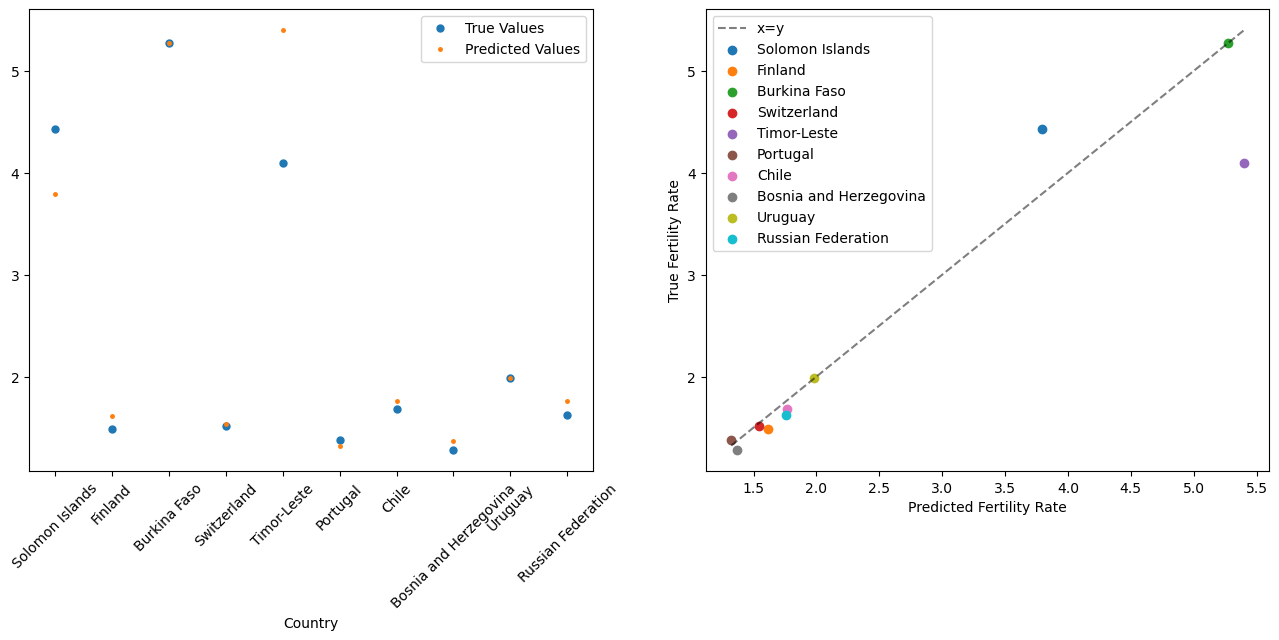

In [40]:
x_ = range(len(countries))
f, ax = plt.subplots(1,2, figsize=(16,6))
plot_sub(ax[0], x_, y_test, label="True Values", ms=10)
plot_sub(ax[0], x_, preds, label="Predicted Values", xlabel="Country")
ax[0].set_xticks(x_, countries, rotation=45)

xy=np.linspace(min(preds), max(preds))
ax[1].plot(xy,xy, "--k", alpha=0.5, label="x=y")
for i, country in enumerate(countries):
    scat_sub(ax[1], [preds[i]], [y_test[i]], xlabel="Predicted Fertility Rate", ylabel="True Fertility Rate", label=country)

# Search Best Parameters for Life Expectancy

In [26]:
life_expect = pd.read_csv("data/life_expectancy.csv")
data = reshape(life_expect)

In [27]:
data_lagged, encoder = to_lagged_mtvs_with_country(data)

## Without Country Information

In [28]:
cols=[f"{-i}" for i in range(1,50+1)] + ["y"]
# Searching without country reference
(best_model, 
 best_params, 
 best_rmse, 
 relative_rmse,
 best_pcorr,
results) = search_best_no_country(X=data,
                            lagged_data=data_lagged[cols],
                            estimator=DecisionTreeRegressor,
                            lags=range(1,50),
                            from_year=range(1960, 2010+1),
                           )

Number of iterations: 2499
Iteration Nº: 200
Iteration Nº: 400
Iteration Nº: 600
Iteration Nº: 800
Iteration Nº: 1000
Iteration Nº: 1200
Iteration Nº: 1400
Iteration Nº: 1600
Iteration Nº: 1800
Iteration Nº: 2000
Iteration Nº: 2200
Iteration Nº: 2400
Processing Finished!


In [29]:
print("Best by Pearson:")
print_all(best_params, best_rmse, best_pcorr, relative_rmse)

Best by Pearson:

    Best Parameters: {'lags': 13, 'encode_country': False, 'train_range': (1979, 2015)}
    Best RMSE: 0.09624970716562356
    Best Pearson Corr.: 0.9999137664793257
    RMSE Relative to Mean: 0.001281122814606596
    


In [30]:
idx = np.argmin(results["rmse"])

print("Best by RMSE:")
print_all(results["params"][idx], results["rmse"][idx], results["pearson"][idx], results["rmse"][idx]/data.loc[2016, countries].mean())

Best by RMSE:

    Best Parameters: {'lags': 13, 'encode_country': False, 'train_range': (1979, 2015)}
    Best RMSE: 0.09624970716562356
    Best Pearson Corr.: 0.9999137664793257
    RMSE Relative to Mean: 0.001281122814606596
    


In [31]:
best_model = ForecastModel(lags=13, encode_country=False).fit(data, start=1979, stop=2015)

In [32]:
save_results("life_expect_dt.pickle", best_model, results["rmse"][idx], results["pearson"][idx])

## With Country Reference

In [42]:
(best_model, 
 best_params, 
 best_rmse, 
 relative_rmse,
 best_pcorr,
results) = search_best_encode_country(  X=data,
                                        lagged_data=data_lagged,
                                        encoder=encoder,
                                        estimator=DecisionTreeRegressor,
                                        lags=range(1,50),
                                        from_year=range(1960, 2010+1),
                                       )

Number of iterations: 2499
Iteration Nº: 200
Iteration Nº: 400
Iteration Nº: 600
Iteration Nº: 800
Iteration Nº: 1000
Iteration Nº: 1200
Iteration Nº: 1400
Iteration Nº: 1600
Iteration Nº: 1800
Iteration Nº: 2000
Iteration Nº: 2200
Iteration Nº: 2400
Processing Finished!


In [43]:
print("Best by Pearson:")
print_all(best_params, best_rmse, best_pcorr, relative_rmse)

Best by Pearson:

    Best Parameters: {'lags': 1, 'encode_country': True, 'train_range': (1963, 2015)}
    Best RMSE: 0.07889036010469028
    Best Pearson Corr.: 0.9999354366948494
    RMSE Relative to Mean: 0.0010500628330092846
    


In [44]:
idx = np.argmin(results["rmse"])

print("Best by RMSE:")
print_all(results["params"][idx], results["rmse"][idx], results["pearson"][idx], results["rmse"][idx]/data.loc[2016, countries].mean())

Best by RMSE:

    Best Parameters: {'lags': 1, 'encode_country': True, 'train_range': (1963, 2015)}
    Best RMSE: 0.07889036010469028
    Best Pearson Corr.: 0.9999354366948494
    RMSE Relative to Mean: 0.0010500628330092846
    


In [45]:
save_results("life_expect_dt_country.pickle", best_model, best_rmse, best_pcorr)

## Results For Life Expectancy Dataset

> Statistics obtained with train test split

| Statistic | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| Pearson Corr. | 0.9999926 | ? | 0.9999354 |
| RMSE | 0.027 | ? | 0.079 |
| RMSE Relative to MEAN| 3.767e-10 | ? | 0.00105 |

> Best parameters obtained

| Parameter | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| lags | 16 | ? | 1 |
| start | 1960 | ? | 1963 |
| stop | 2015 | ? | 2015 |
| encode_country | False | ? | True |

## Predicting Country Life Expectancy Rate for 2017 on the **Test** Set

In [46]:
y_test=pd.read_csv("data/life_expectancy_test.csv", index_col=0).loc[2017]
y_test

Solomon Islands           72.645000
Finland                   81.631707
Burkina Faso              60.768000
Switzerland               83.551220
Timor-Leste               69.007000
Portugal                  81.424390
Chile                     79.909000
Bosnia and Herzegovina    77.128000
Uruguay                   77.632000
Russian Federation        72.451463
Name: 2017, dtype: float64

In [47]:
model = ForecastModel(lags=1, encode_country=True).fit(data, start=1963, stop=2016)

In [48]:
model.X

,-1,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Arab World,Argentina,...,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe
1964,66.787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1965,67.113,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1966,67.435,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1967,67.762,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1968,68.095,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,54.800,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2013,56.516,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2014,58.053,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2015,59.360,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [49]:
preds = [ model.predict([2017], label)[0] for label in countries]
preds

[70.98694581671637,
 81.9484178512935,
 60.689198496015145,
 83.05962627840572,
 69.303906532361,
 81.3619462114703,
 79.83098630882023,
 77.12544520304486,
 77.61070624334188,
 71.62992098426383]

In [50]:
print(f"rmse = {mean_squared_error( y_test, preds, squared=False)}")

rmse = 0.6221618454906803


In [51]:
print(f"Pearson Corr. Coef. = {np.corrcoef(y_test, preds)[0,1]}")

Pearson Corr. Coef. = 0.9964988106415774


In [52]:
print(f"relative rmse = {mean_squared_error( y_test, preds, squared=False) / y_test.mean()}")

relative rmse = 0.008228045648554469


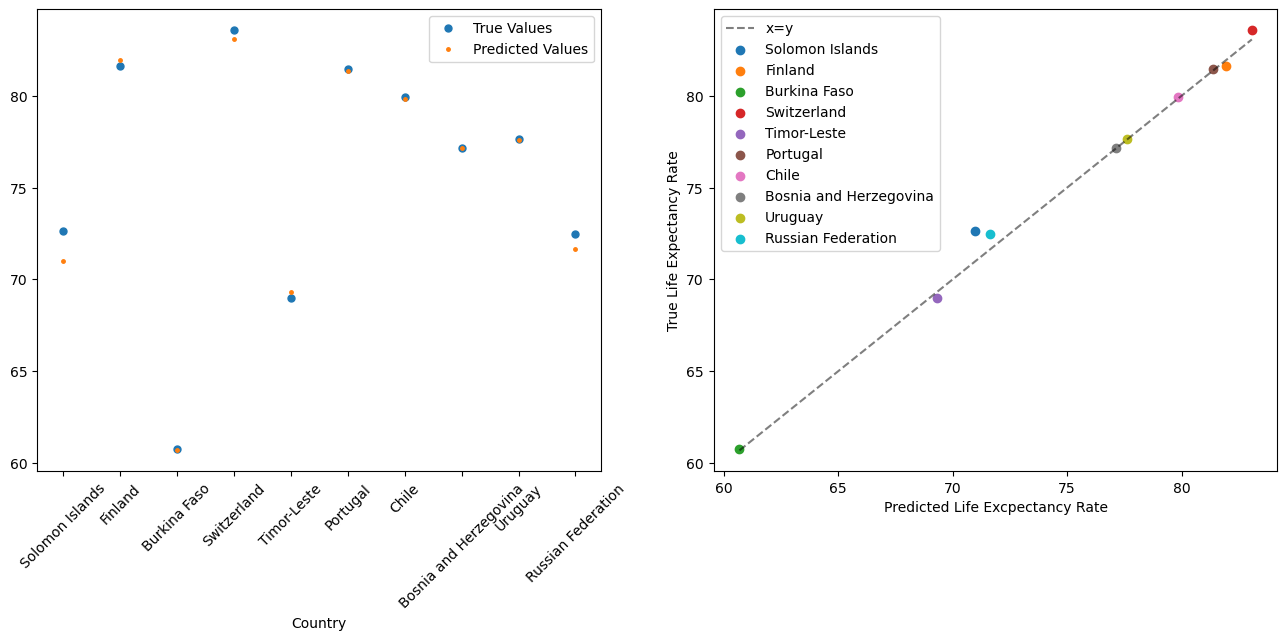

In [53]:
x_ = range(len(countries))
f, ax = plt.subplots(1,2, figsize=(16,6))
plot_sub(ax[0], x_, y_test, label="True Values", ms=10)
plot_sub(ax[0], x_, preds, label="Predicted Values", xlabel="Country")
ax[0].set_xticks(x_, countries, rotation=45)

xy=np.linspace(min(preds), max(preds))
ax[1].plot(xy,xy, "--k", alpha=0.5, label="x=y")
for i, country in enumerate(countries):
    scat_sub(ax[1], [preds[i]], [y_test[i]], xlabel="Predicted Life Excpectancy Rate", ylabel="True Life Expectancy Rate", label=country)